## Reviewing Charles' Work [here](https://github.com/Ficc-ai/ficc/blob/ficc_ml/ml_models/sequence_predictors/history_20230419.ipynb)



A few things to explore: 
1. Why is diff_ys the better label 
2. Paired t-test for model testing 
3. Custom callbacks


try mixed precision policy and engaging tensor cores for float16 operations [here](https://www.tensorflow.org/guide/mixed_precision)


In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import gc

import numpy as np
from google.cloud import bigquery
from google.cloud import storage

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pandas.tseries.offsets import BDay

from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle


from ficc.utils.nelson_siegel_model import *
from ficc.utils.diff_in_days import *
from ficc.utils.auxiliary_functions import sqltodf


from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT, NUM_OF_DAYS_IN_YEAR
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

from ficc_keras_utils import *
import ficc_keras_utils

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(f'TF Version: {tf.__version__}')

2023-05-10 17:41:40.762132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-10 17:41:40.888694: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-10 17:41:40.890072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Initializing pandarallel with 16.0 cores
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
TF Version: 2.7.0


In [31]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/jupyter/ficc/isaac_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

bq_client = bigquery.Client()
storage_client = storage.Client()

##COMMON VARIABLES
#DATA WINDOW
train_start = ficc_keras_utils.train_start
train_end = ficc_keras_utils.train_end
test_start = ficc_keras_utils.test_start
test_end = ficc_keras_utils.test_end
#MODEL PARAMETERS 
VALIDATION_SPLIT = ficc_keras_utils.VALIDATION_SPLIT
LEARNING_RATE = ficc_keras_utils.LEARNING_RATE
BATCH_SIZE = ficc_keras_utils.BATCH_SIZE
NUM_EPOCHS = ficc_keras_utils.NUM_EPOCHS
DROPOUT = ficc_keras_utils.DROPOUT

##NOTEBOOK SPECIFIC VARIABLES 
SEQUENCE_LENGTH = 5
NUM_FEATURES = 6
# target_variable = 'new_ys_diff'
target_variable = 'new_ys'

Load data

In [3]:
from ficc_keras_utils import *

In [4]:
%%time

path = 'processed_file_FULL_2023-05-03-17:08.pkl'#'../processed_file_FULL_2023-04-12-20:44.pkl'
data = load_data_from_pickle(path)

File available, loading pickle
CPU times: user 38.5 s, sys: 17.6 s, total: 56 s
Wall time: 1min 42s


In [5]:
data['new_ys'] = data['yield'] - data['new_ficc_ycl']
data['new_ys_realtime'] = data['yield'] - data['new_real_time_ficc_ycl']
data.dropna(subset=['new_ys', 'new_ys_realtime'], inplace=True)

In [6]:
# data['new_ys_diff'] = data['new_ys'] - data['last_yield_spread']
# data.dropna(subset=['new_ys', 'new_ys_realtime', 'new_ys_diff'], inplace=True)

In [7]:
data.trade_date.max(), data.trade_date.min()

(Timestamp('2023-04-28 00:00:00'), Timestamp('2022-09-01 00:00:00'))

## Adding and Analyzing diff_ys from Charles' notebook

This part tries to gain an understanding of why diff_ys is a more meaningful and predictive label than new_ys. One hypothesis is that this is a first differenced label that exhibits less autocorrelation than new_ys. The detriment of autocorrelation on causal inference is clearer than prediction - it may not necessarily negatively influence predictions. 

But one hypothesis (how to test?) is that the distribution of the label is more stable over time when first-differencing the data, allowing more stable and accurate estimates over time.

In [ ]:
data['new_ys_diff'] = data['new_ys'] - data['last_yield_spread']
data['new_ys_realtime_diff'] = data['new_ys_realtime'] - data['last_yield_spread_realtime']

Checking to see if the realtime labels and non-realtime labels are consistent:

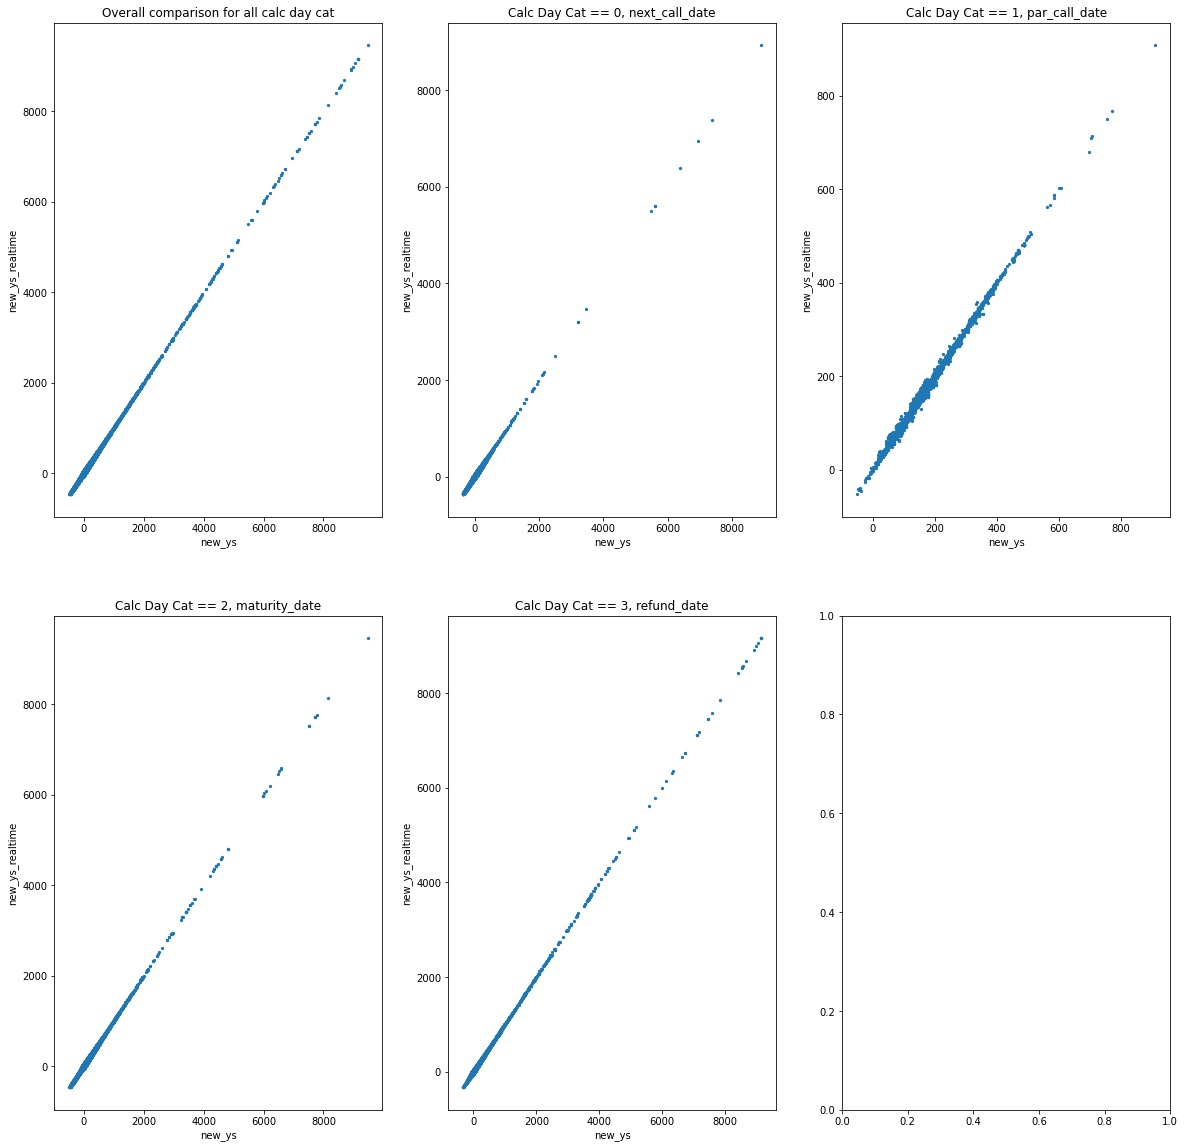

In [9]:
sanity_check(data, ['new_ys', 'new_ys_realtime'])

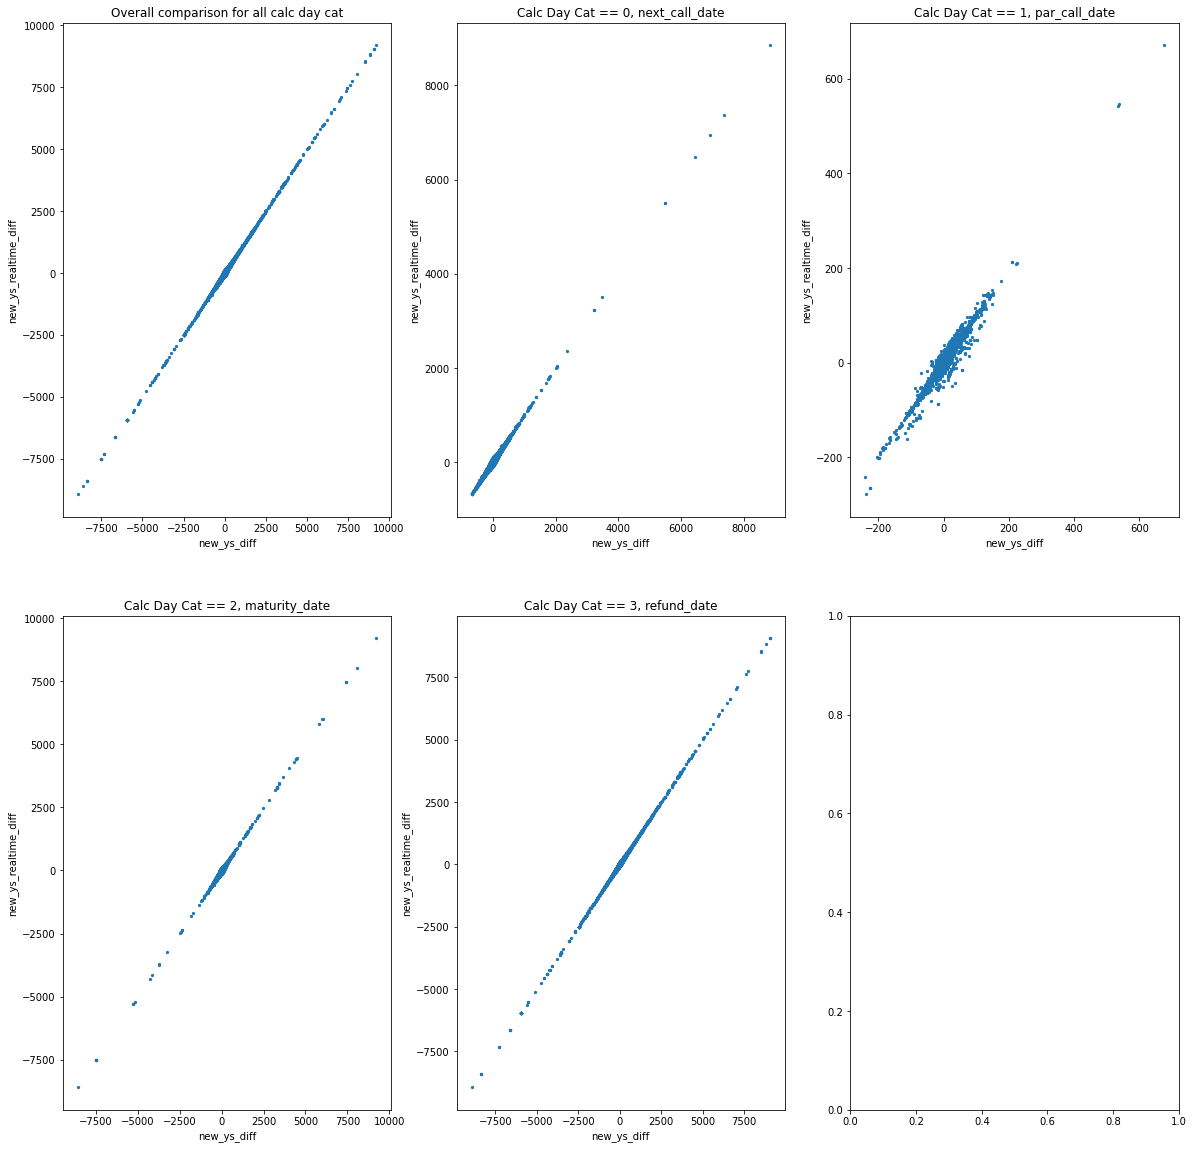

In [55]:
sanity_check(data, ['new_ys_diff', 'new_ys_realtime_diff'])

For efficiency we work on a subset of the data just from January onwards:

In [10]:
target_candidates = ['new_ys_realtime',  'new_ys_realtime_diff', 'new_ys', 'new_ys_diff']
data_subset = data[data.trade_date > '2023-01-01']

Here we define trade history as past trades in the main trade dataframe (so a row with the same cusip). We don't use the trade trade history column, since that does not show any trade dates and might exclude extremely recent trades. The autocorrelation of order L measures the correlation between the observed value of a variable at time T and it's value L time steps ago. Here we look at order 1 autocorrelations (ACR). 

This is not exact, since autocorrelations are usually calculated using fixed time intervals, but here a time step is simply when a past trade occurs - it could be 1 minute ago or 1 year ago.

To reduce noise, we look at cusips with at least 3 observations in the trade dataframe. In otherwords, we are looking at cusips that have traded at least 3 times since 2023-01.

In [35]:
# def plot_histogram(data, ax = None, title = None, xlim = None, ylim = None, xlabel = None, ylabel = None):
    

In [51]:
def calculate_acr_for_targets(data, lag_order = 1, do_abs = False, history_size = 3 ,target_candidates=target_candidates):
    print(f'Calculating the average within-cusip ACR of order {lag_order} for cusips that have traded at least {history_size} times since {min(data.trade_date)}.')
    size = data.groupby('cusip').size()
    size = size[size>history_size].index
    print(f'N = {len(size)}\n')
    grouping_df = data[data.cusip.isin(size)].sort_values(by='trade_datetime', ascending=True).groupby('cusip')

    acr = {}
    fig, ax = plt.subplots(len(target_candidates), 2,
                           figsize=(10*len(target_candidates), 25))

    for i, col in enumerate(target_candidates):
        data_subset[col].hist(figsize=(8,8), bins=500, ax=ax[i, 0])
        ax[i, 0].set_title(f'Histogram of {col}')

        if 'diff' in col: ax[i, 0].set_xlim(-150 , 150)
        else: ax[i, 0].set_xlim(-300,300)

        acr[col] = grouping_df[col].apply(lambda x: x.autocorr(lag=lag_order))
        

    for i, k in enumerate(acr.keys()):
        v = acr[k]
        v.hist(ax=ax[i,1], bins = 500)
        ax[i,1].set_title(f'Histogram for ACR of {k}')
        if do_abs:
            va = np.abs(v)
            print(f'TARGET {k}, ACR Absolute\n Mean: {va.mean():.2f}, Std: {va.std():.2f}, Max: {va.max():.2f}, Min: {va.min():.2f}\n 75th Percentile: {va.quantile(.75):.2f}, 25th Percentile: {va.quantile(.25):.2f} \n'+'='*50)
        print(f'TARGET {k}, ACR\n Mean: {v.mean():.2f}, Std: {v.std():.2f}, Max: {v.max():.2f}, Min: {v.min():.2f}\n 75th Percentile: {v.quantile(.75):.2f}, 25th Percentile: {v.quantile(.25):.2f} , Median: {v.median():.2f}\n'+'='*50)
        
    plt.tight_layout()
    
    return acr
    
def acr_plot_for_cusip(target_cusip, data_subset=data_subset, target_candidates = target_candidates):
    target_cusip_df = data_subset[data_subset.cusip == target_cusip].sort_values(by='trade_datetime', ascending=True)

    target_acr = {}
    for col in target_candidates:
        temp = target_cusip_df[[col]]
        for i in range(1,11):
            temp[str(i)] = target_cusip_df[col].shift(i)
        target_acr[col] = temp.corr()[col]

    fig, ax = plt.subplots(len(target_candidates), figsize=(10, len(target_candidates)*5))

    for i, axes in enumerate(ax):
        col = target_candidates[i]
        target_acr[col].drop(col).plot(kind='bar',
                             ax=axes, 
                             title = f'Autocorrelation Plot for {col} \nN = {len(target_cusip_df)} since {target_cusip_df.trade_date.min()}')
        axes.set_xlabel('Lag')
        axes.set_ylabel('Autocorrelation')
        axes.set_ylim(-1,1)
        axes.grid(True)
        
    fig.suptitle('CUSIP: '+target_cusip, y = .99)
    plt.tight_layout()

Calculating the average within-cusip ACR of order 1 for cusips that have traded at least 15 times since 2022-09-01 00:00:00.
N = 100570

TARGET new_ys_realtime, ACR
 Mean: 0.47, Std: 0.24, Max: 1.00, Min: -0.99
 75th Percentile: 0.64, 25th Percentile: 0.33 , Median: 0.50
TARGET new_ys_realtime_diff, ACR
 Mean: 0.18, Std: 0.24, Max: 1.00, Min: -1.00
 75th Percentile: 0.34, 25th Percentile: 0.03 , Median: 0.18
TARGET new_ys, ACR
 Mean: 0.47, Std: 0.24, Max: 1.00, Min: -1.00
 75th Percentile: 0.64, 25th Percentile: 0.33 , Median: 0.50
TARGET new_ys_diff, ACR
 Mean: 0.17, Std: 0.23, Max: 1.00, Min: -0.97
 75th Percentile: 0.33, 25th Percentile: 0.02 , Median: 0.18
CPU times: user 2min 25s, sys: 2.06 s, total: 2min 27s
Wall time: 2min 26s


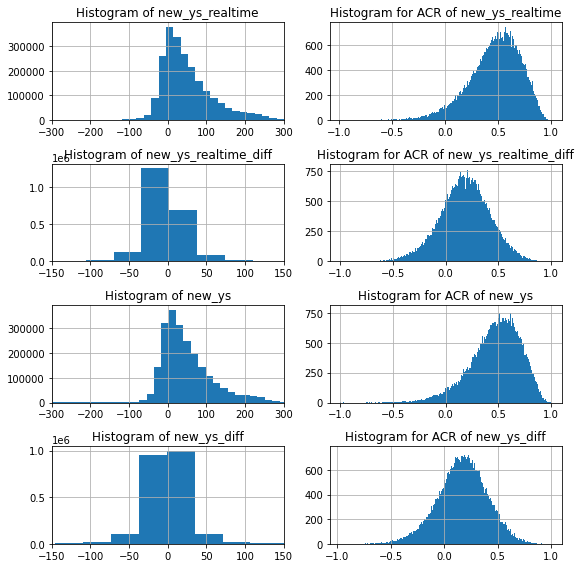

In [39]:
%%time
acr = calculate_acr_for_targets(data, history_size = 15)

Calculating the average within-cusip ACR of order 1 for cusips that have traded at least 6 times since 2022-09-01 00:00:00.
N = 197087

TARGET new_ys_realtime, ACR
 Mean: 0.40, Std: 0.30, Max: 1.00, Min: -1.00
 75th Percentile: 0.63, 25th Percentile: 0.23 , Median: 0.45
TARGET new_ys_realtime_diff, ACR
 Mean: 0.18, Std: 0.30, Max: 1.00, Min: -1.00
 75th Percentile: 0.38, 25th Percentile: 0.00 , Median: 0.20
TARGET new_ys, ACR
 Mean: 0.40, Std: 0.30, Max: 1.00, Min: -1.00
 75th Percentile: 0.62, 25th Percentile: 0.24 , Median: 0.45
TARGET new_ys_diff, ACR
 Mean: 0.17, Std: 0.29, Max: 1.00, Min: -1.00
 75th Percentile: 0.37, 25th Percentile: -0.01 , Median: 0.19
CPU times: user 4min 27s, sys: 2.45 s, total: 4min 30s
Wall time: 4min 30s


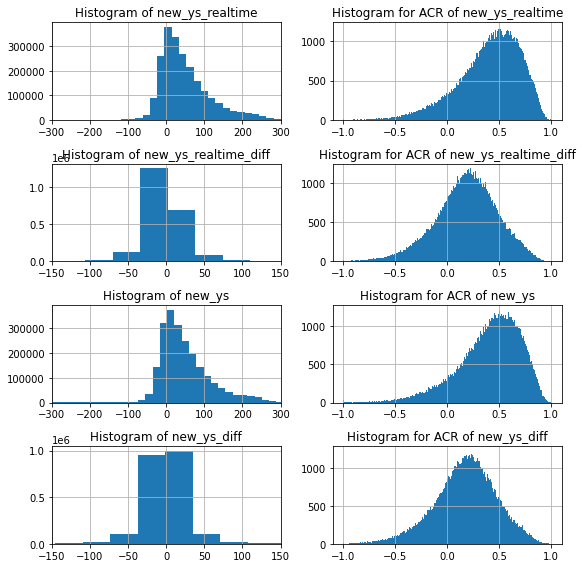

In [37]:
%%time
acr = calculate_acr_for_targets(data, history_size = 6)

Calculating the average within-cusip ACR of order 1 for cusips that have traded at least 6 times since 2022-09-01 00:00:00.
N = 197087

TARGET new_ys_realtime, ACR
 Mean: 0.40, Std: 0.30, Max: 1.00, Min: -1.00
 75th Percentile: 0.63, 25th Percentile: 0.23 
TARGET new_ys_realtime_diff, ACR
 Mean: 0.18, Std: 0.30, Max: 1.00, Min: -1.00
 75th Percentile: 0.38, 25th Percentile: 0.00 
TARGET new_ys, ACR
 Mean: 0.40, Std: 0.30, Max: 1.00, Min: -1.00
 75th Percentile: 0.62, 25th Percentile: 0.24 
TARGET new_ys_diff, ACR
 Mean: 0.17, Std: 0.29, Max: 1.00, Min: -1.00
 75th Percentile: 0.37, 25th Percentile: -0.01 


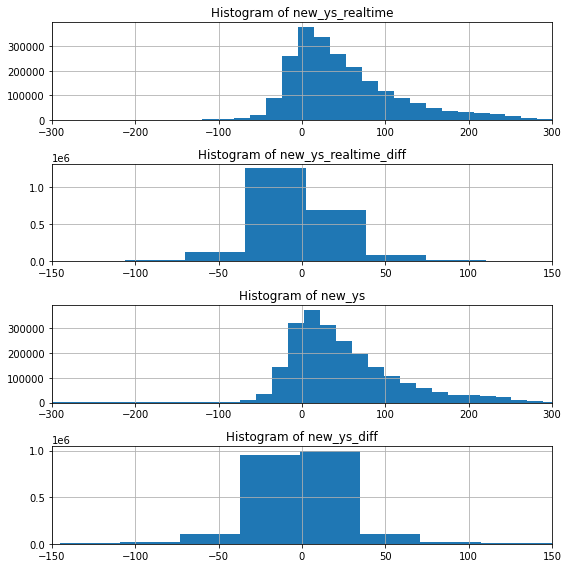

In [13]:
acr = calculate_acr_for_targets(data, history_size = 6)

Calculating the average within-cusip ACR of order 1 for cusips that have traded at least 3 times since 2023-01.
N = 111016

TARGET new_ys_realtime, ACR
 Mean: 0.28, Std: 0.44, Max: 1.00, Min: -1.00
 75th Percentile: 0.60, 25th Percentile: 0.04 
TARGET new_ys_realtime_diff, ACR
 Mean: 0.16, Std: 0.43, Max: 1.00, Min: -1.00
 75th Percentile: 0.50, 25th Percentile: -0.11 
TARGET new_ys, ACR
 Mean: 0.27, Std: 0.43, Max: 1.00, Min: -1.00
 75th Percentile: 0.59, 25th Percentile: 0.02 
TARGET new_ys_diff, ACR
 Mean: 0.16, Std: 0.43, Max: 1.00, Min: -1.00
 75th Percentile: 0.49, 25th Percentile: -0.11 


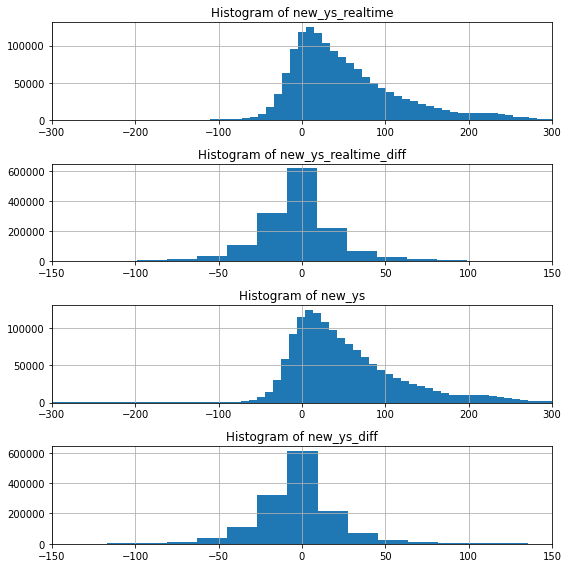

In [65]:
calculate_acr_for_targets(data_subset)

Calculating the average within-cusip ACR of order 2 for cusips that have traded at least 3 times since 2023-01.
N = 111016

TARGET new_ys_realtime, ACR
 Mean: 0.03, Std: 0.60, Max: 1.00, Min: -1.00
 75th Percentile: 0.50, 25th Percentile: -0.41 
TARGET new_ys_realtime_diff, ACR
 Mean: -0.13, Std: 0.58, Max: 1.00, Min: -1.00
 75th Percentile: 0.21, 25th Percentile: -0.53 
TARGET new_ys, ACR
 Mean: 0.02, Std: 0.60, Max: 1.00, Min: -1.00
 75th Percentile: 0.46, 25th Percentile: -0.43 
TARGET new_ys_diff, ACR
 Mean: -0.13, Std: 0.57, Max: 1.00, Min: -1.00
 75th Percentile: 0.21, 25th Percentile: -0.53 


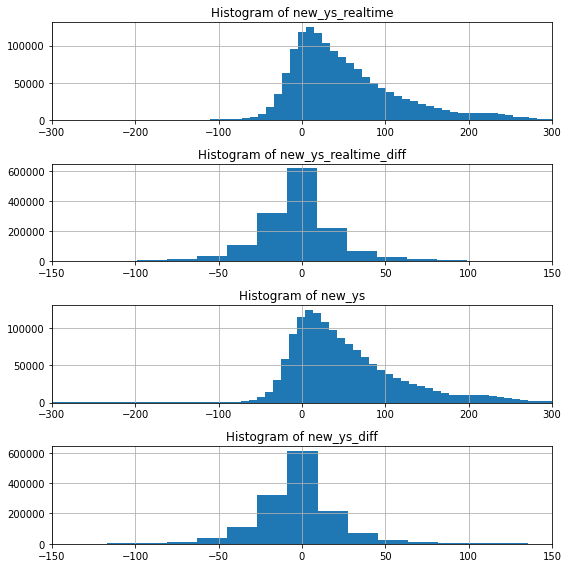

In [66]:
calculate_acr_for_targets(data_subset, lag_order=2)

Unsurprisingly, the average autocorrelation decreases when we use diff_ys, because this is close but not equivalent to a proper first-differencing of the data. Intuitively, first-differencing reduces autocorrelation because it strips out the deterministic autocorrelated term (lagged values of the target variable) and isolates the random noise/innovation term between time steps. 

Autocorrelation Plots for Specific cusips: 

In [41]:
most_common_cusips = data_subset.groupby('cusip').size().sort_values(ascending=False).head(5)
most_common_cusips = data_subset[data_subset.cusip.isin(most_common_cusips.index)]

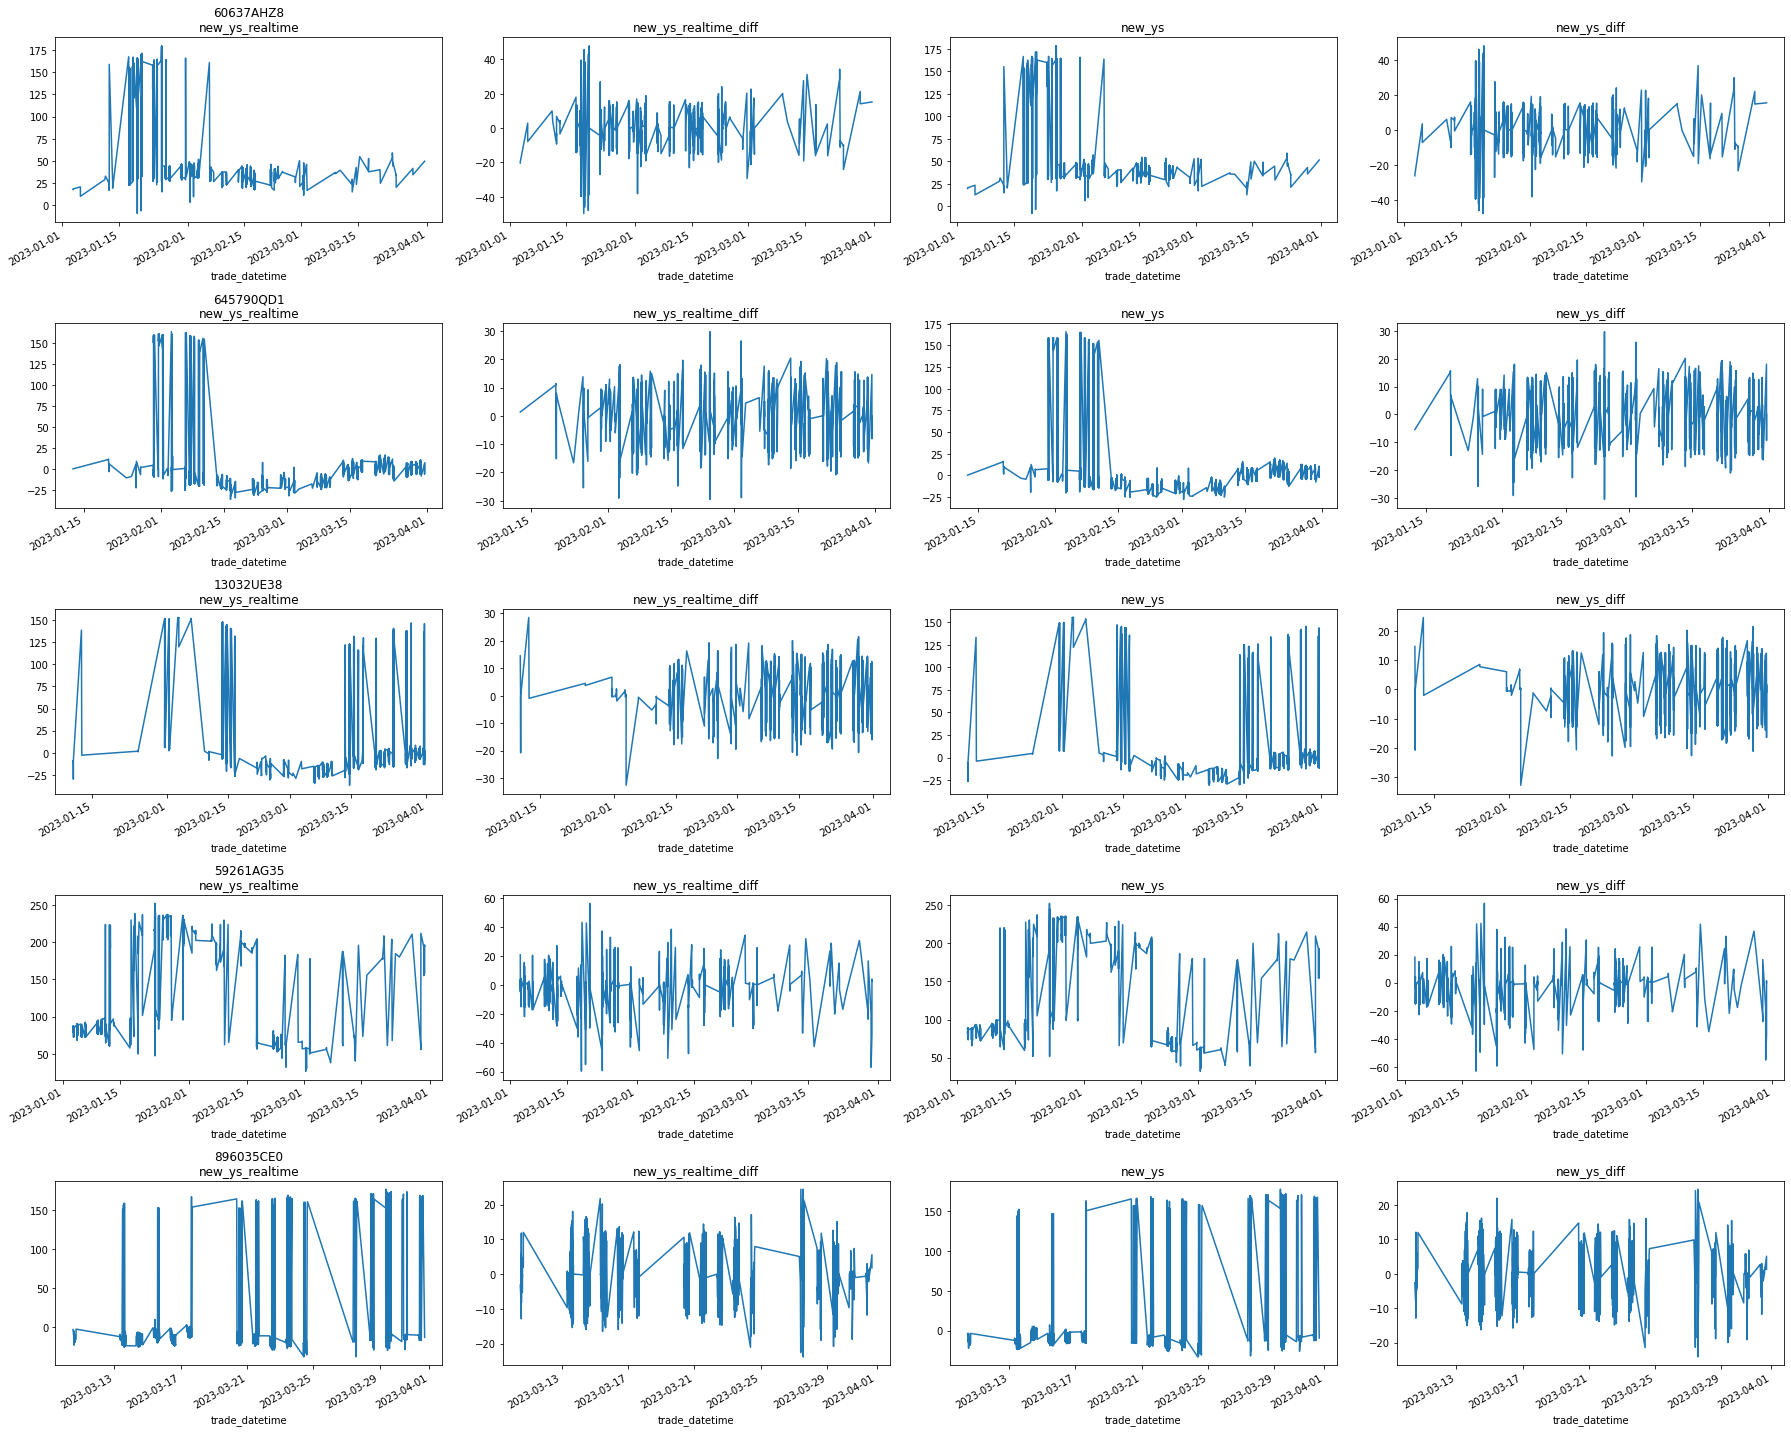

In [42]:
#These are actual spread values in basis points
fig, ax = plt.subplots(5, 4, figsize=(25, 20))

for row, cusip in enumerate(most_common_cusips.cusip.unique()):
    sub = most_common_cusips[most_common_cusips.cusip == cusip].sort_values(by='trade_datetime')
    for column, target in enumerate(target_candidates):
        sub.set_index('trade_datetime')[target].plot(ax = ax[row, column])
        if column == 0:  ax[row, column].set_title(cusip+f'\n{target}')
        else: ax[row, column].set_title(target)

plt.tight_layout()

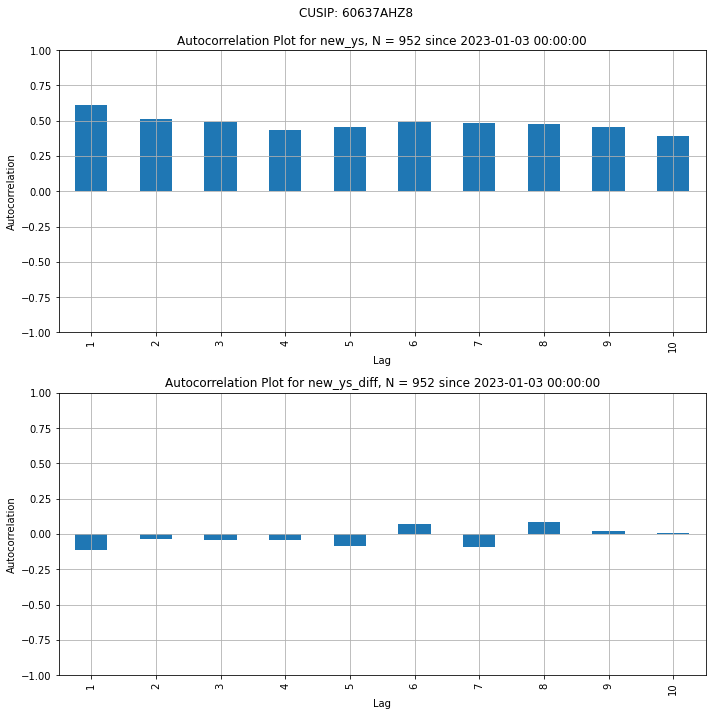

In [53]:
acr_plot_for_cusip(most_common_cusips.cusip.unique()[0], data_subset = data, target_candidates = ['new_ys','new_ys_diff'])

Another interesting question to ask is: do any cusips have autocorrelation that persists after first-differencing via diff_ys?

In [70]:
size = data_subset.groupby('cusip').size()
size = size[size>3]

result = data_subset[data_subset.cusip.isin(size.index)].sort_values(by='trade_date', ascending=True).groupby('cusip')['new_ys_diff']\
.agg([lambda x: x.autocorr(lag=1),lambda x: x.std()])

result = pd.concat([size, result], axis = 1).rename({0:'Trade History Size', '<lambda_0>':'ACR', '<lambda_1>':'SD'}, axis=1)

In [71]:
result[np.abs(result.ACR) > .75].sort_values(by=['Trade History Size', 'ACR',], ascending=False).head(50)

,Trade History Size,ACR,SD
cusip,,,
386676FC9,172,0.954,3.610
62620HCN0,85,0.901,11.276
52385LCU1,81,0.877,24.074
59259YNC9,69,0.757,647.073
57587GWB7,48,0.957,6.029
641279TA2,46,0.807,0.824
700739NH4,42,0.877,5.176
56035DEL2,40,1.000,0.000
71883RQL0,38,0.986,2.507


In [72]:
size = data_subset.groupby('cusip').size()
size = size[size>3]

result = data_subset[data_subset.cusip.isin(size.index)].sort_values(by='trade_date', ascending=True).groupby('cusip')['new_ys']\
.agg([lambda x: x.autocorr(lag=1),lambda x: x.std()])

result = pd.concat([size, result], axis = 1).rename({0:'Trade History Size', '<lambda_0>':'ACR', '<lambda_1>':'SD'}, axis=1)
result[np.abs(result.ACR) > .75].sort_values(by=['Trade History Size', 'ACR',], ascending=False).head(50)

,Trade History Size,ACR,SD
cusip,,,
59261AG35,788,0.806,63.116
64577BTL8,396,0.932,48.801
850001AZ1,379,0.781,24.158
98322QE52,370,0.873,55.104
57584YQJ1,336,0.955,60.979
118217CZ9,316,0.763,9.669
37353PKS7,315,0.823,50.495
646140DJ9,279,0.830,52.945
650036AK2,258,0.754,45.856


In [74]:
data_subset[data_subset.cusip=='59259YNC9'][['rtrs_control_number','trade_datetime', 'yield', 'new_ys', 'last_yield_spread', 'new_ys_diff']].sort_values(by='rtrs_control_number').head(50)

,rtrs_control_number,trade_datetime,yield,new_ys,last_yield_spread,new_ys_diff
793003,2023010304189600,2023-01-03 11:49:33,1427.300,1113.463,4181.305,-3067.842
793002,2023010304190500,2023-01-03 11:49:34,1427.300,1113.463,4181.305,-3067.842
793058,2023010304190900,2023-01-03 11:49:00,1427.300,1113.463,4181.305,-3067.842
788728,2023010305254300,2023-01-03 12:33:30,416.500,102.455,1113.255,-1010.800
788727,2023010305254500,2023-01-03 12:33:30,416.500,102.455,1113.255,-1010.800
766225,2023010400113000,2023-01-04 08:00:09,416.500,108.346,102.455,5.891
746896,2023010405511500,2023-01-04 11:52:25,416.400,108.179,108.279,-0.100
746898,2023010405514900,2023-01-04 11:52:25,416.400,108.179,108.279,-0.100
737623,2023010407950000,2023-01-04 13:18:33,416.400,108.179,108.179,0.000
737622,2023010407950200,2023-01-04 13:18:33,416.400,108.179,108.179,0.000


Making the target more gaussian:

Log transformations dont achieve the same effect, though in general they had to pull in longer right tails. Heuristically, looking at the distribution of values, it does not seem like yield spread is log-normal. Only diff_ys seems to have the intended impact of making the target variable gaussian.

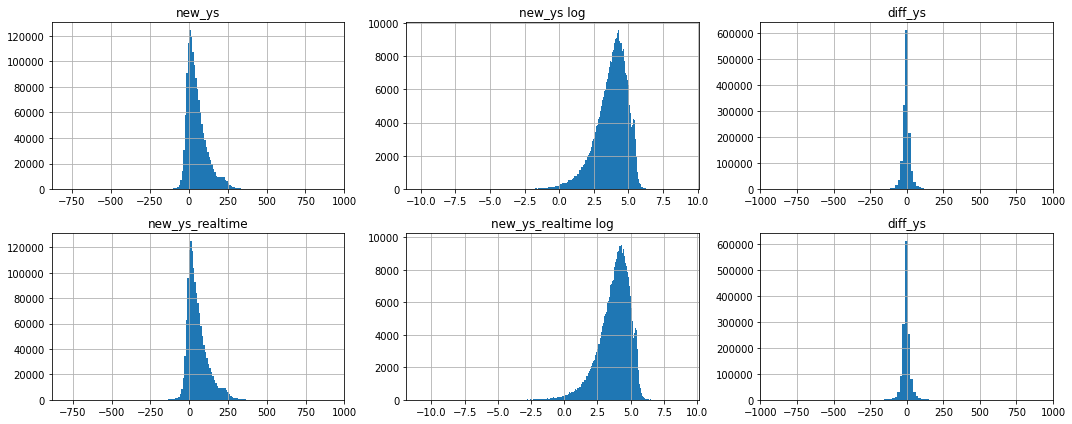

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6))

for i, col in enumerate(['new_ys', 'new_ys_realtime']):
    data_subset[col].hist(ax=ax[i, 0], bins=1000)
    data_subset[col].apply(lambda x: np.log(x+0.001)).hist(ax=ax[i, 1], bins=1000)
    (data_subset[col]-data_subset['last_yield_spread']).hist(ax=ax[i, 2], bins=1000)
    
    ax[i, 0].set_title(f'{col}') 
    ax[i, 0].set_xlim(right=1000)
    ax[i, 1].set_title(f'{col} log')
    ax[i, 2].set_title(f'diff_ys')
    ax[i, 2].set_xlim(-1000,1000)
    
plt.tight_layout()

In [38]:
data['year'] = data.trade_date.dt.year
data['month'] =  data.trade_date.dt.month

temp = data.groupby(['year','month'])[target_candidates].agg(['mean', 'std'])

<AxesSubplot:xlabel='year,month'>

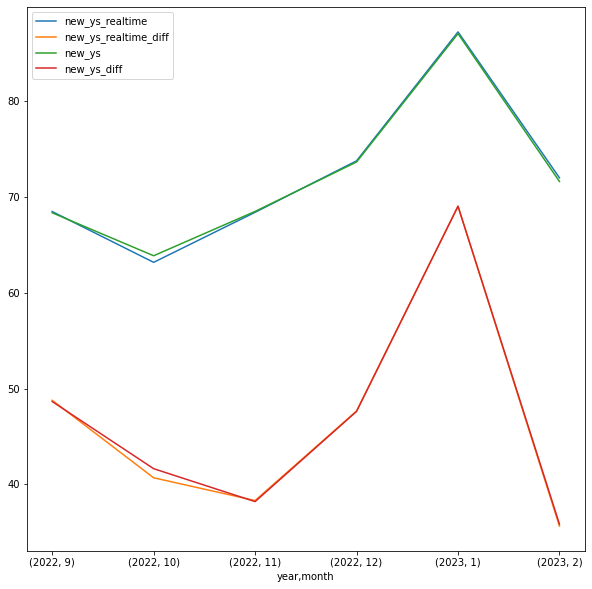

In [41]:
data.groupby(['year','month'])[target_candidates].apply(lambda x: x.std()).plot(figsize=(10,10))

We also see that the standard deviation decreases when we use diff_ys compared to new_ys, and because the two variables are measured in the same units we can say with some objectivity that first-differencing reduces the amount of noise in the data. The variance from the sum (or difference) of two random variables is the sum of their variances, but if we are taking the difference between two related variables, then we must add (subtract) 2 times of their covariance. 

$\sigma^2_{(X-Y)} = \sigma^2_X + \sigma^2_Y - 2COV(X,Y)$

In general, autocorrelation presents a problem for causal inference in econometric-type studies, but in prediction the impact of autocorrelation is not entirely apparent. Insofar as it reduces noise in the variable it might be a useful feature engineering technique. To that end, it seems like diff_ys is closer to Gaussian than regular new_ys, which has a long-tail like many financial variables. 

In [ ]:
data['new_ficc_ycl'].std()

60.82893314404067

In [ ]:
data['last_ficc_ycl'].std()

71.86257458862168

In [ ]:
(data['new_ficc_ycl']- data['last_ficc_ycl']).std()

41.568876489609686

# Testing Ideas

In [8]:
auxiliary_features = ['dollar_price',
                      'last_calc_date',
                     'calc_date', 
                     'trade_date',
                      'last_trade_date',
                     'trade_datetime', 
                     'purpose_sub_class', 
                     'called_redemption_type', 
                     'calc_day_cat',
                     'yield',
                     'ficc_ycl',
                     #'same_ys',
                     #'trade_history_sum',
                     'new_ficc_ycl',
                      'new_real_time_ficc_ycl',
                     'days_to_refund',
                      'last_dollar_price',
                      'last_rtrs_control_number',
                     'is_called',
                     ]

In [9]:
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')
    
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')
    
for col in ['new_ficc_ycl', 'new_real_time_ficc_ycl']:     
    if col not in PREDICTORS:
        PREDICTORS.append(col)
        NON_CAT_FEATURES.append(col)

for col in ['extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit']:     
    if col not in data.columns:
        try: 
            print(f'Removing {col} from PREDICTORS and BINARY')
            BINARY.remove(col)
            PREDICTORS.remove(col) 
        except:
            continue

In [10]:
def process_data(data): 
    data['ted-rate'] = (data['t_rate_10'] - data['t_rate_2']) * 100
    
    # Here is a list of exclusions that we will be experimenting with. The model is trained with these exclusions. These exclusions were discussed with a team member.
    # Callable less than a year in the future
    # Maturity less than a year in the future and more than 30 years in the future
    
    data = data[(data.days_to_call == 0) | (data.days_to_call > np.log10(400))]
    data = data[(data.days_to_refund == 0) | (data.days_to_refund > np.log10(400))]
    data = data[(data.days_to_maturity == 0) | (data.days_to_maturity > np.log10(400))]
    data = data[data.days_to_maturity < np.log10(30000)]
    data['trade_history_sum'] = data.trade_history.parallel_apply(lambda x: np.sum(x))
    data.issue_amount = data.issue_amount.replace([np.inf, -np.inf], np.nan)
    data.dropna(inplace=True, subset=PREDICTORS+['trade_history_sum'])
    data.purpose_sub_class.fillna(0, inplace=True)
    
    # data['calc_date_duration'] = data[['last_calc_date','last_trade_date']].parallel_apply(get_calc_date_duration, axis=1)
    # data['new_ficc_ycl_fixed_shape'] = data[['trade_date', 'calc_date_duration']].parallel_apply(lambda x: calculate_ycl(x, new_yc_params), axis = 1)
    # data['new_ficc_ycl_prev_day'] = data[['last_calc_date', 'last_trade_date' ,'calc_date_duration','trade_date']].parallel_apply(get_yield_for_last_duration, axis=1)
    
    return data

In [11]:
%%time

processed_data = process_data(data) 
processed_data = processed_data.drop(51570)
# processed_data = processed_data[IDENTIFIERS + PREDICTORS + auxiliary_features]

CPU times: user 54.5 s, sys: 18.8 s, total: 1min 13s
Wall time: 1min 19s


In [12]:
processed_data.reset_index(inplace=True, drop=True)

In [13]:
encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    print(f)
    fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates()) #note that there are apparently no trades with CC 
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

rating
incorporated_state_code
trade_type
purpose_class


In [20]:
%%time

processed_data['trade_history_fixed'] = processed_data['trade_history'].apply(lambda x: x[::-1, :])

CPU times: user 3.52 s, sys: 336 ms, total: 3.86 s
Wall time: 3.86 s


In [21]:
train_filter = (processed_data.trade_date < train_end) & (processed_data.trade_date >= train_start)
test_filter = (processed_data.trade_date >= test_start) & (processed_data.trade_date <test_end)
                                                            
train_dataframe = processed_data[train_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

test_dataframe = processed_data[test_filter]\
.sort_values(by='trade_date', ascending=True)\
.reset_index(drop=True)

print('Training data start: {}, end: {}'.format(train_dataframe.trade_date.min(),train_dataframe.trade_date.max()))
print('Training data start: {}, end: {}'.format(test_dataframe.trade_date.min(),test_dataframe.trade_date.max()))

Training data start: 2022-11-01 00:00:00, end: 2023-02-28 00:00:00
Training data start: 2023-03-01 00:00:00, end: 2023-03-31 00:00:00


In [39]:
def create_input(df):
    global encoders
    datalist = []
    datalist.append(np.stack(df['trade_history'].to_numpy()))
    # datalist.append(np.stack(df['trade_history_fixed'].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

In [40]:
%%time
np.random.seed(0)
val_idx = np.random.choice(range(len(train_dataframe)), 
                 size = int(VALIDATION_SPLIT*len(train_dataframe)),
                 replace=False)

print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

x_train = create_input(train_dataframe.drop(val_idx, axis=0))
y_train = train_dataframe.drop(val_idx, axis=0)[target_variable]

x_val = create_input(train_dataframe.iloc[val_idx])
y_val = train_dataframe.iloc[val_idx][target_variable]

x_test = create_input(test_dataframe)
y_test = test_dataframe[target_variable]

TRAINING DATA: N = 2600040, MIN DATE = 2022-11-01 00:00:00, MAX DATE = 2023-02-28 00:00:00
VALIDATION DATA: N = 650010, MIN DATE = 2022-11-01 00:00:00, MAX DATE = 2023-02-28 00:00:00
TEST DATA: N = 708432, MIN DATE = 2023-03-01 00:00:00, MAX DATE = 2023-03-31 00:00:00
CPU times: user 27.4 s, sys: 2.58 s, total: 30 s
Wall time: 30 s


## Model Training and Testing

In [41]:
# Normalization layer for the trade history
trade_history_normalizer = Normalization(name='Trade_history_normalizer')
trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

# Normalization layer for the non-categorical and binary features
noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

tf.keras.utils.set_random_seed(10)

In [42]:
def generate_model(SEQUENCE_LENGTH = SEQUENCE_LENGTH ,NUM_FEATURES = NUM_FEATURES, trade_history_normalizer = trade_history_normalizer):
    inputs = []
    layer = []

    ############## INPUT BLOCK ###################
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(SEQUENCE_LENGTH,NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(SEQUENCE_LENGTH, 3), 
                                       dtype = tf.float32) 


    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM')

    lstm_attention_layer = CustomAttention(56)

    lstm_layer_2 = layers.LSTM(100, 
                               activation='tanh',
                               input_shape=(SEQUENCE_LENGTH,50),
                               return_sequences = False,
                               name='LSTM_2')


    features = lstm_layer(trade_history_normalizer(inputs[0]))
    features = lstm_attention_layer(features, features, inputs[1])
    features = layers.BatchNormalization()(features)
    # features = layers.Dropout(DROPOUT)(features)

    features = lstm_layer_2(features)
    features = layers.BatchNormalization()(features)
    # features = layers.Dropout(DROPOUT)(features)

    trade_history_output = layers.Dense(100, 
                                        activation='relu')(features)

    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f]+1,
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)


    reference_hidden = layers.Dense(400,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))

    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_output = layers.Dense(100,activation='tanh',name='reference_hidden_3')(reference_hidden2)

    ####################################################

    feed_forward_input = layers.concatenate([reference_output, trade_history_output])

    hidden = layers.Dense(300,activation='relu')(feed_forward_input)
    hidden = layers.BatchNormalization()(hidden)
    hidden = layers.Dropout(DROPOUT)(hidden)

    hidden2 = layers.Dense(100,activation='relu')(hidden)
    hidden2 = layers.BatchNormalization()(hidden2)
    hidden2 = layers.Dropout(DROPOUT)(hidden2)

    final = layers.Dense(1, dtype='float32')(hidden2)

    model = keras.Model(inputs=inputs, outputs=final)
    
    return model

def create_tf_data(x_train, y_train, shuffle=False, shuffle_buffer=1):
                     
    X=()
    for x in x_train:
        X += (tf.data.Dataset.from_tensor_slices(x),)
        

    temp = tf.data.Dataset.zip((X))
    del X
    dataset = tf.data.Dataset.zip((temp,
                        tf.data.Dataset.from_tensor_slices(y_train)))
    del temp
    if shuffle:
        shuffle_buffer = int(len(x_train[0])*shuffle_buffer)
        dataset = dataset.shuffle(shuffle_buffer)
        
    return dataset

In [43]:
def train_model(x_train, y_train, x_val, y_val, shuffle, shuffle_buffer=1):
    tf.keras.backend.clear_session()
    gc.collect()

    timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')
    
    fit_callbacks = fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True),
        # time_callback,
        CSVLoggerTimeHistory(timestamp+'_training_logs.csv', separator=",", append=False)]
    
    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()

    model_new_ys = generate_model(SEQUENCE_LENGTH=SEQUENCE_LENGTH,
                                  NUM_FEATURES=NUM_FEATURES, 
                                  trade_history_normalizer = trade_history_normalizer)
    
    model_new_ys.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
          loss=keras.losses.MeanAbsoluteError(),
          metrics=[keras.metrics.MeanAbsoluteError()])

    history_new_ys = model_new_ys.fit(train_ds,
                                      validation_data=val_ds,
                                        epochs=NUM_EPOCHS,     
                                        verbose=1, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    return history_new_ys, model_new_ys

In [ ]:
from sklearn.metrics import mean_absolute_error

results = []
predictions = []

for i in range(8):
    history, model = train_model(x_train, y_train, x_val, y_val, shuffle=True, shuffle_buffer=0.75)
    pred = model.predict(x_test)
    predictions.append(pred)
    print('='*25+f' TRIAL {i}, MAE: {mean_absolute_error(pred,y_test)} '+'='*25)
    results.append([history, model])

Epoch 1/100


2023-05-11 06:26:02.329405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 955063 of 1950030
2023-05-11 06:26:12.329384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:380] Filling up shuffle buffer (this may take a while): 1678500 of 1950030


   1/2540 [..............................] - ETA: 19:02:40 - loss: 58.4334 - mean_absolute_error: 58.4334

2023-05-11 06:26:14.996361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:405] Shuffle buffer filled.


2540/2540 [==============================] - 86s 23ms/step - loss: 16.8640 - mean_absolute_error: 16.8640 - val_loss: 10.6718 - val_mean_absolute_error: 10.6718
Epoch 2/100
2540/2540 [==============================] - 33s 13ms/step - loss: 10.9125 - mean_absolute_error: 10.9125 - val_loss: 10.0206 - val_mean_absolute_error: 10.0206
Epoch 3/100
2540/2540 [==============================] - 38s 15ms/step - loss: 10.6239 - mean_absolute_error: 10.6239 - val_loss: 9.8775 - val_mean_absolute_error: 9.8775
Epoch 4/100
2540/2540 [==============================] - 33s 13ms/step - loss: 10.4586 - mean_absolute_error: 10.4586 - val_loss: 9.7819 - val_mean_absolute_error: 9.7819
Epoch 5/100
2540/2540 [==============================] - 38s 15ms/step - loss: 10.3344 - mean_absolute_error: 10.3344 - val_loss: 9.6846 - val_mean_absolute_error: 9.6846
Epoch 6/100
2540/2540 [==============================] - 37s 15ms/step - loss: 10.2356 - mean_absolute_error: 10.2356 - val_loss: 9.5653 - val_mean_absol

Here we are using the paired t-test to test for a difference in means. The variable in question here is the absolute error, and we are therefore asking if the mean absolute error between two different sets of predictions are equal. If they are equal, then the two models are, at least functionally, the same. An important assumption is that the distribution of the difference is normal - this has to be tested.

When we do a paired t-test using predictions from two models of the same architecture, the result provides us with an estimate of the level of noise we can expect from two functionally similar models. Differences between two functionally similar models are hence 2 sigma about the mean value, so if SD = 0.05 and Mean = 0.1, then differences between MAE within the interval of [0, 0.2] are statistically insignificant.

In [47]:
for i, prediction in enumerate(predictions):
    print(f'{mean_absolute_error(prediction, y_test)}')

9.859499981748442
9.600041737553385
9.674591766874112
9.657406262268038
9.620180216179888
9.580721354364172
9.789713420322991
9.675962249606966


In [60]:
test_dataframe.to_pickle('experiments_2023-04-30.pkl')

In [49]:
def compareacc(data, col1, col2, actual, thresh=100000):
    import scipy.stats as stats
    
    tr = (data.par_traded >= thresh)
    print( f"Comparing models on {tr.sum()} trades >= ${thresh}" )
    testdf = data[tr]
    preds1 = data[col1]
    preds2 = data[col2]
    ae1 = (preds1 - actual).abs()
    ae2 = (preds2 - actual).abs()
    denom = np.sqrt(len(actual))
    print( f"model 1 MAE = {ae1.mean():6.3f} +/- {ae1.std()/denom:6.3f} stderr" )
    print( f"model 2 MAE = {ae2.mean():6.3f} +/- {ae2.std()/denom:6.3f} stderr" )
    diff = ae2 - ae1
    print( f"AE2 - AE1 mean = {diff.mean():6.3f} +/- {diff.std()/denom:6.3f} stderr" )
    Z = diff.mean()/(diff.std()/denom)
    print( f'Test Statistic: {Z:.2f}, two-tailed p-value {stats.norm.sf(abs(Z))*2:.2f}' )
    print(f'Scipy t-test {stats.ttest_rel(ae1, ae2)}')
    bool = diff < 0
    print( f"model 1 win rate = {bool.mean():7.4f} +/- {bool.std()/denom:7.4f} stderr\n" )

In [50]:
# with open('saved_models.pkl', 'wb') as f: 
#     pickle.dump(results, f)

In [57]:
for i,  (model1, model2) in enumerate(zip(results, results_full)):
    model1[1].save(f'model_{i}_partial_shuffle')
    model2[1].save(f'model_{i}_full_shuffle')

2023-04-30 07:55:21.572231: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2023-04-30 07:55:24.235730: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


INFO:tensorflow:Assets written to: model_0_partial_shuffle/assets


INFO:tensorflow:Assets written to: model_0_partial_shuffle/assets


INFO:tensorflow:Assets written to: model_0_full_shuffle/assets


INFO:tensorflow:Assets written to: model_0_full_shuffle/assets


INFO:tensorflow:Assets written to: model_1_partial_shuffle/assets


INFO:tensorflow:Assets written to: model_1_partial_shuffle/assets


INFO:tensorflow:Assets written to: model_1_full_shuffle/assets


INFO:tensorflow:Assets written to: model_1_full_shuffle/assets


INFO:tensorflow:Assets written to: model_2_partial_shuffle/assets


INFO:tensorflow:Assets written to: model_2_partial_shuffle/assets


INFO:tensorflow:Assets written to: model_2_full_shuffle/assets


INFO:tensorflow:Assets written to: model_2_full_shuffle/assets


INFO:tensorflow:Assets written to: model_3_partial_shuffle/assets


INFO:tensorflow:Assets written to: model_3_partial_shuffle/assets


INFO:tensorflow:Assets written to: model_3_full_shuffle/assets


INFO:tensorflow:Assets written to: model_3_full_shuffle/assets


In [51]:
#with full buffer
compareacc(test_dataframe, 'prediction_1', 'prediction_2', y_test, thresh=100000)
compareacc(test_dataframe, 'prediction_1', 'prediction_3', y_test, thresh=100000)
compareacc(test_dataframe, 'prediction_1', 'prediction_4', y_test, thresh=100000)
compareacc(test_dataframe, 'prediction_2', 'prediction_3', y_test, thresh=100000)
compareacc(test_dataframe, 'prediction_2', 'prediction_4', y_test, thresh=100000)
compareacc(test_dataframe, 'prediction_3', 'prediction_4', y_test, thresh=100000)

Comparing models on 294243 trades >= $100000
model 1 MAE = 10.783 +/-  0.012 stderr
model 2 MAE = 10.704 +/-  0.012 stderr
AE2 - AE1 mean = -0.079 +/-  0.006 stderr
Test Statistic: -12.25, two-tailed p-value 0.00
Scipy t-test Ttest_relResult(statistic=12.253422568951466, pvalue=1.617467555905197e-34)
model 1 win rate =  0.5045 +/-  0.0004 stderr

Comparing models on 294243 trades >= $100000
model 1 MAE = 10.783 +/-  0.012 stderr
model 2 MAE = 11.142 +/-  0.012 stderr
AE2 - AE1 mean =  0.359 +/-  0.007 stderr
Test Statistic: 54.91, two-tailed p-value 0.00
Scipy t-test Ttest_relResult(statistic=-54.9132045246044, pvalue=0.0)
model 1 win rate =  0.4766 +/-  0.0004 stderr

Comparing models on 294243 trades >= $100000
model 1 MAE = 10.783 +/-  0.012 stderr
model 2 MAE = 10.520 +/-  0.012 stderr
AE2 - AE1 mean = -0.263 +/-  0.006 stderr
Test Statistic: -41.05, two-tailed p-value 0.00
Scipy t-test Ttest_relResult(statistic=41.04837982793495, pvalue=0.0)
model 1 win rate =  0.5213 +/-  0.0004 

In [38]:
compareacc(test_dataframe, 'prediction_1', 'prediction_2', y_test, thresh=100000)
compareacc(test_dataframe, 'prediction_1', 'prediction_3', y_test, thresh=100000)
compareacc(test_dataframe, 'prediction_1', 'prediction_4', y_test, thresh=100000)
compareacc(test_dataframe, 'prediction_2', 'prediction_3', y_test, thresh=100000)
compareacc(test_dataframe, 'prediction_2', 'prediction_4', y_test, thresh=100000)
compareacc(test_dataframe, 'prediction_3', 'prediction_4', y_test, thresh=100000)

Comparing models on 294243 trades >= $100000
model 1 MAE = 10.735 +/-  0.012 stderr
model 2 MAE = 10.770 +/-  0.012 stderr
AE2 - AE1 mean =  0.034 +/-  0.006 stderr
Test Statistic: 5.35, two-tailed p-value 0.00
Scipy t-test Ttest_relResult(statistic=-5.3521988538413465, pvalue=8.69061832967616e-08)
model 1 win rate =  0.4957 +/-  0.0004 stderr

Comparing models on 294243 trades >= $100000
model 1 MAE = 10.735 +/-  0.012 stderr
model 2 MAE = 10.621 +/-  0.012 stderr
AE2 - AE1 mean = -0.114 +/-  0.006 stderr
Test Statistic: -17.63, two-tailed p-value 0.00
Scipy t-test Ttest_relResult(statistic=17.633459423209743, pvalue=1.3888299629122196e-69)
model 1 win rate =  0.5111 +/-  0.0004 stderr

Comparing models on 294243 trades >= $100000
model 1 MAE = 10.735 +/-  0.012 stderr
model 2 MAE = 10.728 +/-  0.012 stderr
AE2 - AE1 mean = -0.007 +/-  0.006 stderr
Test Statistic: -1.17, two-tailed p-value 0.24
Scipy t-test Ttest_relResult(statistic=1.1702729939978425, pvalue=0.24189133623077663)
mode